# Test two final models (Best and Proposed)

---

### Importing the libraries

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, utils
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import sys
sys.path.insert(0, '../helpers/')
from plot_graphs import plot_loss, plot_acc

### Setting batch and image size, and importing the datasets 

In [10]:
IMAGE_SIZE = 100
BATCH_SIZE = 32

train = utils.image_dataset_from_directory("../datasets/data/split/Zenodo/train", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)
val = utils.image_dataset_from_directory("../datasets/data/split/Zenodo/val", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)
test = utils.image_dataset_from_directory("../datasets/data/split/Zenodo/test", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)

train = train.prefetch(buffer_size=tf.data.AUTOTUNE).cache()
val = val.prefetch(buffer_size=tf.data.AUTOTUNE).cache()
test = test.prefetch(buffer_size=tf.data.AUTOTUNE).cache()

Found 3840 files belonging to 6 classes.
Found 480 files belonging to 6 classes.
Found 480 files belonging to 6 classes.


### Processing images

In [11]:
def process_image(x):
  x = tf.image.adjust_brightness(x, 0.8)
  x = tf.image.adjust_contrast(x, 3)
  x = tf.image.adjust_saturation(x, 2)
  return x

def process_ds(dataset):
  return dataset.map(lambda x, y: (process_image(x), y)).prefetch(tf.data.AUTOTUNE).cache()
  
train_processed = process_ds(train)
val_processed = process_ds(val)
test_processed = process_ds(test)

### Function to generate confusion matrices and get class-wise precision and recall

In [12]:
class_list = ['bike', 'car', 'juggernaut', 'minibus', 'pickup', 'truck']

# Get the labels(y_true) and predictions(y_pred) from the test set
def get_preds_labels(model,test):
  preds = np.argmax(model.predict(test), axis=1)
  labels = []
  for image, label in test.unbatch():
    labels.append(label)
  labels = np.array(labels)

  return labels, preds

# print the classification report and confusion matrix
def print_cm(labels, preds, cm):
  print(classification_report(labels, preds))

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_list)

  plt.rcParams["figure.figsize"] = (15,8)

  disp.plot(cmap=plt.cm.Blues)
  plt.show()


## 1. Best Model - highest accuracy

> In this section, the best model which will now be trained for 50 epochs with slightly tweaked dropout and learning rates to maximize test accuracy.

### 1.1 Defining the best model

In [14]:
inputs = keras.Input(shape=(100, 100, 3))
x = inputs
x = layers.Rescaling(1./255)(x)

layer_architecture = {32: 3, 64: 2, 128: 2, 256: 2}

for size in layer_architecture:
  for i in range(layer_architecture[size]):
    x = layers.Conv2D(size, 3, activation='relu')(x)
  if size != 256:
    x = layers.MaxPooling2D(2)(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model_best = keras.Model(inputs, outputs)

model_best.compile(optimizer=keras.optimizers.RMSprop(0.00095), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_best.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 conv2d_10 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 94, 94, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                           

### 1.2 Running the best model

In [15]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath="../models/4_best_model.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]

history_best = model_best.fit(
  train_processed,
  epochs=50,
  callbacks=callbacks_list,
  validation_data=val_processed
)

2022-09-01 08:21:49.788628: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2022-09-01 08:21:50.335258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 1.7209 - accuracy: 0.3372

2022-09-01 08:22:02.214657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 13s 98ms/step - loss: 1.7209 - accuracy: 0.3372 - val_loss: 1.1544 - val_accuracy: 0.6000
Epoch 2/50
120/120 [==============================] - 12s 96ms/step - loss: 0.9463 - accuracy: 0.6435 - val_loss: 1.3101 - val_accuracy: 0.5083
Epoch 3/50
120/120 [==============================] - 11s 92ms/step - loss: 0.6263 - accuracy: 0.7781 - val_loss: 1.3327 - val_accuracy: 0.5271
Epoch 4/50
120/120 [==============================] - 12s 96ms/step - loss: 0.4126 - accuracy: 0.8628 - val_loss: 0.5386 - val_accuracy: 0.8125
Epoch 5/50
120/120 [==============================] - 12s 100ms/step - loss: 0.3061 - accuracy: 0.8964 - val_loss: 0.3530 - val_accuracy: 0.8833
Epoch 6/50
120/120 [==============================] - 12s 100ms/step - loss: 0.2123 - accuracy: 0.9229 - val_loss: 0.3527 - val_accuracy: 0.8917
Epoch 7/50
120/120 [==============================] - 14s 115ms/step - loss: 0.1904 - accuracy: 0.9372 - val_loss: 0.4028 - val_accuracy: 0.8958


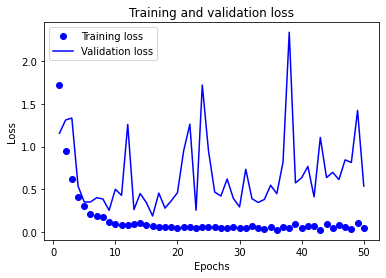

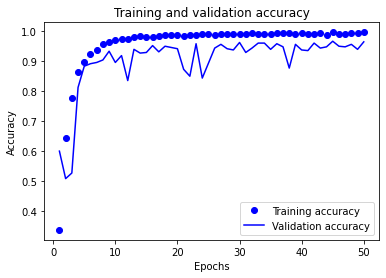

In [16]:
plt.rcParams["figure.figsize"] = (6,4)
plot_loss(history_best)
plot_acc(history_best)

### 1.3 Evaluating test accuracy of the best model

In [17]:
load_model_best = keras.models.load_model("../models/4_best_model.h5")
load_model_best.evaluate(test_processed)

2022-09-01 08:38:46.007367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 32ms/step - loss: 0.9207 - accuracy: 0.9583


[0.9206554293632507, 0.9583333730697632]

---

*Test Accuracy*: **95.83%**

---

### 1.4 Confusion matrix and class-wise precious and recall for best model

2022-09-01 08:47:52.452497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.99      0.99      0.99        80
           1       0.97      0.96      0.97        80
           2       0.99      0.96      0.97        80
           3       0.95      0.90      0.92        80
           4       0.95      0.99      0.97        80
           5       0.93      0.97      0.95        80

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480



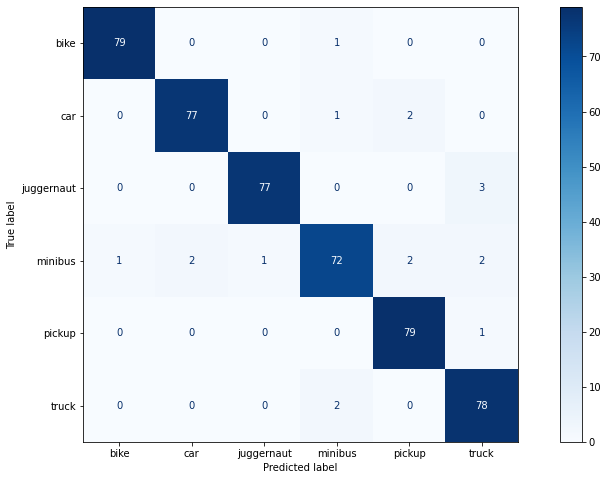

In [18]:
best_labels, best_preds = get_preds_labels(model_best, test_processed)
cm_proposed = confusion_matrix(best_labels, best_preds)
print_cm(best_labels, best_preds, cm_proposed)

----

## 2. Proposed Model - the smallest model that gives the highest accuracy

> In this section, the small proposed model will run for 50 epochs to check the test accuracy it gives.

### 2.1 Defining the proposed model

In [15]:
inputs = keras.Input(shape=(100, 100, 3))
x = inputs
x = layers.Conv2D(16, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model_proposed = keras.Model(inputs, outputs)

model_proposed.compile(optimizer=keras.optimizers.RMSprop(0.0009), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_proposed.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 21, 21, 32)        9248

### 2.2 Running the proposed model

In [16]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10
    ),    
    keras.callbacks.ModelCheckpoint(
        filepath="../models/4_proposed_model.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]

history_proposed = model_proposed.fit(
  train,
  epochs=50,
  callbacks=callbacks_list,
  validation_data=val
)

Epoch 1/50


2022-08-31 22:53:28.569765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


118/120 [============================>.] - ETA: 0s - loss: 2.3335 - accuracy: 0.2182

2022-08-31 22:53:31.762201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 4s 25ms/step - loss: 2.3244 - accuracy: 0.2190 - val_loss: 1.7639 - val_accuracy: 0.2896
Epoch 2/50
120/120 [==============================] - 3s 24ms/step - loss: 1.6613 - accuracy: 0.3245 - val_loss: 1.4745 - val_accuracy: 0.4042
Epoch 3/50
120/120 [==============================] - 3s 23ms/step - loss: 1.3978 - accuracy: 0.4630 - val_loss: 1.0321 - val_accuracy: 0.6063
Epoch 4/50
120/120 [==============================] - 3s 23ms/step - loss: 1.2168 - accuracy: 0.5599 - val_loss: 0.8604 - val_accuracy: 0.7104
Epoch 5/50
120/120 [==============================] - 3s 22ms/step - loss: 1.0398 - accuracy: 0.6255 - val_loss: 0.7878 - val_accuracy: 0.7042
Epoch 6/50
120/120 [==============================] - 3s 22ms/step - loss: 0.8990 - accuracy: 0.6625 - val_loss: 0.7154 - val_accuracy: 0.7542
Epoch 7/50
120/120 [==============================] - 3s 23ms/step - loss: 0.8003 - accuracy: 0.7042 - val_loss: 0.5962 - val_accuracy: 0.7896
Epoch 8/50

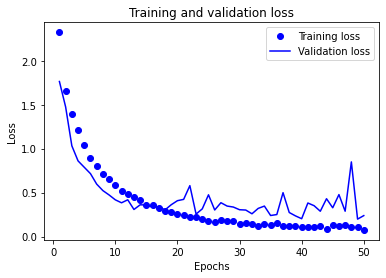

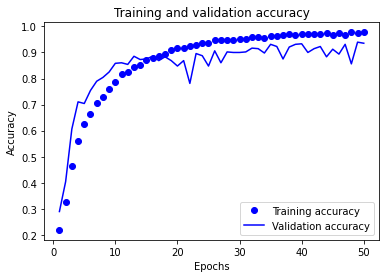

In [17]:
plt.rcParams["figure.figsize"] = (6,4)
plot_loss(history_proposed)
plot_acc(history_proposed)

### 2.3 Evaluating the test accuracy of the proposed model

In [18]:
load_model_proposed = keras.models.load_model("../models/4_proposed_model.h5")
load_model_proposed.evaluate(test)

 5/15 [=========>....................] - ETA: 0s - loss: 0.1673 - accuracy: 0.9375

2022-08-31 22:56:03.826264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 0s 13ms/step - loss: 0.1993 - accuracy: 0.9396


[0.19925062358379364, 0.9395833611488342]

---

*Test Accuracy*: **93.96%**

---

### 2.4 Confusion matrix and class-wise precious and recall for proposed model

2022-08-31 22:56:10.908193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       1.00      0.99      0.99        80
           1       0.88      1.00      0.94        80
           2       0.95      0.97      0.96        80
           3       0.90      0.90      0.90        80
           4       0.96      0.86      0.91        80
           5       0.93      0.89      0.91        80

    accuracy                           0.94       480
   macro avg       0.94      0.94      0.94       480
weighted avg       0.94      0.94      0.94       480



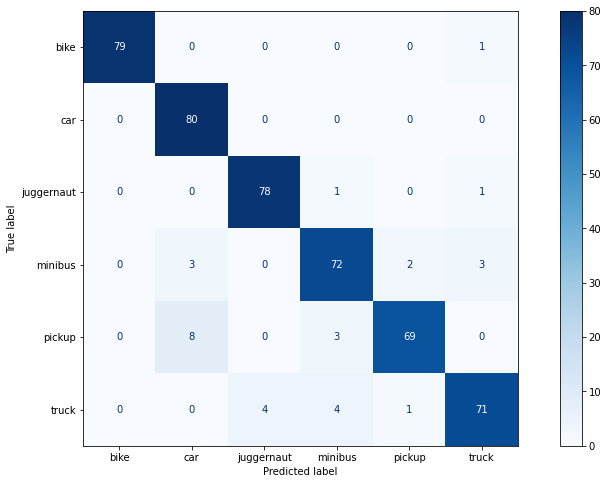

In [19]:
proposed_labels, proposed_preds = get_preds_labels(model_proposed, test)
cm_proposed = confusion_matrix(proposed_labels, proposed_preds)
print_cm(proposed_labels, proposed_preds, cm_proposed)